In [1]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 3.4 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425350 sha256=922409ab655857305c483cb184673282472b980c426847f5308f62ed2911db6d
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark


In [2]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.types import (
    ArrayType, IntegerType, FloatType, DoubleType, 
    StringType, TimestampType
)
from pyspark.sql.functions import (
    col, count, length, size, split, udf, when, isnan, 
    explode, array_min, array_max, array_distinct, 
    to_timestamp, explode
)

from pyspark.ml import Pipeline
from pyspark.ml.clustering import LDA
from pyspark.ml.feature import Tokenizer, CountVectorizer, NGram, IDF

import spacy
from spacy import displacy
import pandas as pd
pd.set_option('display.max_columns', None)

from tqdm import tqdm
from itertools import chain
from collections import Counter

import seaborn as sns
import matplotlib.pyplot as plt

# import textstat
from wordcloud import WordCloud

# from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [3]:
spark = SparkSession \
    .builder \
    .config("spark.driver.memory", "20g") \
    .config("spark.driver.maxResultSize", "10g") \
    .config("spark.jars", "postgresql-42.6.0.jar") \
    .appName("Yelp Review Sense - EDA Text") \
    .getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/11/12 14:50:09 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [5]:
# Define the JDBC connection details
jdbc_url = "jdbc:postgresql://intentionally-removed.amazonaws.com/yelpreviewsense"
db_table = ""
db_user = "postgres"
db_password = ""

# Specify the read options
read_options = {
    "url": jdbc_url,
    "driver": "org.postgresql.Driver",
    "dbtable": db_table,
    "user": db_user,
    "password": db_password,
}

# Read the table into a PySpark DataFrame
df = spark.read.format("jdbc").options(**read_options).load()
df.printSchema()

root
 |-- review_id: string (nullable = true)
 |-- business_id: string (nullable = true)
 |-- user_id: string (nullable = true)
 |-- review_date: timestamp (nullable = true)
 |-- review_stars: double (nullable = true)
 |-- review_text: string (nullable = true)
 |-- review_total_interaction: integer (nullable = true)
 |-- review_sentiment: integer (nullable = false)
 |-- user_yelping_since: timestamp (nullable = true)
 |-- user_review_count: integer (nullable = true)
 |-- user_average_stars: double (nullable = true)
 |-- user_fans: integer (nullable = true)
 |-- user_friends_count: integer (nullable = true)
 |-- user_total_interactions: integer (nullable = true)
 |-- user_total_compliments: integer (nullable = true)
 |-- user_elite_years_count: integer (nullable = true)
 |-- user_elite_min_year: integer (nullable = true)
 |-- user_elite_max_year: integer (nullable = true)
 |-- business_name: string (nullable = true)
 |-- business_city: string (nullable = true)
 |-- business_state: strin

In [7]:
# Selecting Relevant Columns for EDA with Textual Data
df = df.select("review_id", "review_text", "review_cleaned_text", "review_sentiment")
df.show()

+--------------------+--------------------+--------------------+----------------+
|           review_id|         review_text| review_cleaned_text|review_sentiment|
+--------------------+--------------------+--------------------+----------------+
|--7f0VAcFgpK3Hz8u...|Excellent service...|excellent service...|               1|
|--CQtyFgZgR5LAGsp...|I was visiting th...|visiting area sin...|               0|
|--DcWXBx2ei_ME39L...|Good stuff even f...|good stuff even n...|               1|
|--DogY-DxnpGI6HgI...|First time I went...|first time went s...|               1|
|--IF66GYbzkOwz2-7...|Yum!!  My 12 yr o...|yum yr old loved ...|               1|
|--JWxWEceX96_Zrkh...|I should put no s...|put stars didnt a...|               0|
|--KLruLzCEqSzzDTc...|Great, friendly s...|great friendly se...|               1|
|--P30N4O3X5YOH2J2...|Johnny grits is A...|johnny grits awes...|               1|
|--RsqK4awL5fYKTzZ...|BBQ sandwiches ar...|bbq sandwiches re...|               0|
|--SHVffglnCHWXQ

In [8]:
# Checking Null Values in Each Column
df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns]).toPandas()

,review_id,review_text,review_cleaned_text,review_sentiment
0,0,0,0,0


## Word Cloud

/opt/conda/lib/python3.10/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


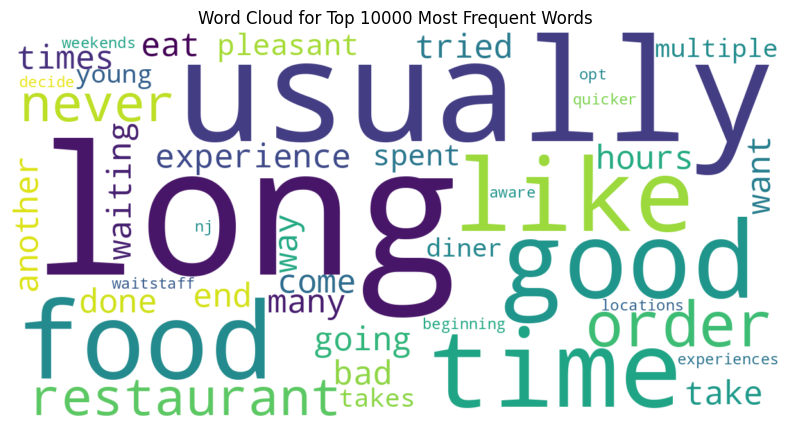

In [28]:
# Tokenize the review_cleaned_text column
tokenizer = Tokenizer(inputCol="review_cleaned_text", outputCol="tokens")
tokenized_df = tokenizer.transform(df)

# Count the frequency of each word
count_vectorizer = CountVectorizer(inputCol="tokens", outputCol="features", vocabSize=10000, minDF=5)
model = count_vectorizer.fit(tokenized_df)
count_vectorized_df = model.transform(tokenized_df)

# Extract the vocabulary and their frequencies
vocabulary = model.vocabulary
word_frequencies = count_vectorized_df.select("features").collect()[0]["features"].toArray()
word_freq_dict = dict(zip(vocabulary, word_frequencies))

wordcloud = WordCloud(width=1200, height=600, max_words=10000, background_color='white').generate_from_frequencies(word_freq_dict)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Top 10000 Most Frequent Words')
plt.show()

#### Conclusion

The word cloud analysis illuminates key recurring terms within the dataset, presenting a comprehensive snapshot of prevalent themes and sentiments. The larger prominence of words such as 'long,' 'usually,' 'like,' 'good,' 'food,' and 'time' emphasizes a focus on the duration of experiences, subjective evaluations, and the quality of dining encounters. Frequent mentions of 'time,' 'order,' 'experience,' and 'spent' underscore a narrative centered around the process and duration of engaging with services or products. The presence of 'order,' 'experience,' 'restaurant,' and 'waiting' indicates a significant engagement with the dynamics of service, dining, and the time spent in these establishments.

The inclusion of words like 'never,' 'tried,' 'pleasant,' and 'going' implies a spectrum of diverse experiences, with some being novel and enjoyable while others may not be. 'Waiting,' 'hours,' and 'another' highlight aspects of time management and potential delays in service. The words 'want,' 'take,' 'weekend,' and 'young' provide additional context, suggesting a desire for certain experiences, possibly during leisure times or by a particular demographic.

## N-gram Exploration

N-gram analysis was conducted to gain insights into the most common single words (unigrams) and two-word combinations (bigrams) within the text data. The objective was to identify key phrases and words that frequently appeared in different sentiment categories, aiding in understanding what customers frequently mentioned in their reviews and how these words or phrases might influence their sentiments.

In [11]:
# Function to generate and count n-grams
def generate_and_count_ngrams(df, n, sentiment_values, num_top_ngrams):
    ngram_counts = []
    
    for sentiment_value in sentiment_values:
        tokenizer = Tokenizer(inputCol="review_cleaned_text", outputCol="words")
        words_df = tokenizer.transform(df.filter(df.review_sentiment == sentiment_value))
        
        ngram = NGram(n=n, inputCol="words", outputCol="ngrams")
        ngrams_df = ngram.transform(words_df)
        
        ngram_counts_ = ngrams_df.select("ngrams").rdd.flatMap(lambda x: x[0]).countByValue()
        top_ngrams = sorted(ngram_counts_.items(), key=lambda x: x[1], reverse=True)[:num_top_ngrams]
        
        ngram_counts.append((sentiment_value, top_ngrams))
    
    return ngram_counts

# Function to plot n-grams
def plot_ngrams(ngram_counts, ngram_type, num_top_ngrams):
    num_subplots = len(ngram_counts)
    
    sns.set(style="whitegrid")
    plt.figure(figsize=(12, 3 * num_subplots))
    
    for i, (sentiment_value, ngrams) in enumerate(ngram_counts):
        plt.subplot(1, num_subplots, i + 1)
        sns.barplot(x=[ngram[1] for ngram in ngrams], y=[ngram[0] for ngram in ngrams], palette="Blues_d")
        plt.title(f"{ngram_type} Analysis - Sentiment {sentiment_value}")
        plt.xlabel("Count")
        plt.ylabel(f"{ngram_type}s")
    
    plt.tight_layout()
    plt.show()

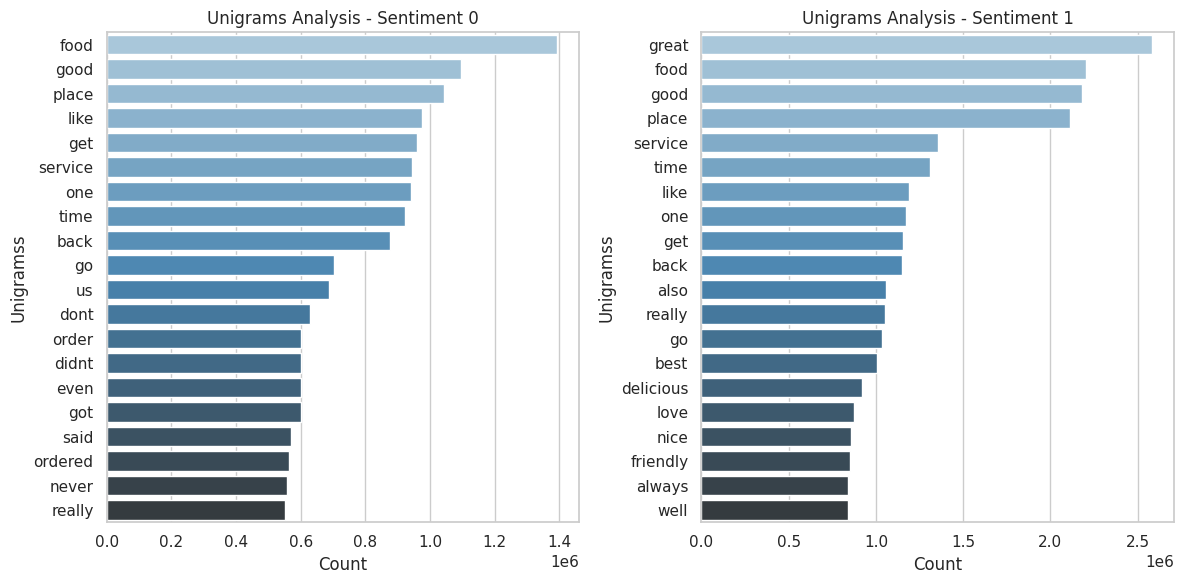

In [17]:
ngram_type = "Unigrams"
num_top_ngrams = 20

sentiment_values = [0, 1]
ngram_counts = generate_and_count_ngrams(df, 1, sentiment_values, num_top_ngrams)
plot_ngrams(ngram_counts, ngram_type, num_top_ngrams)

#### Positive Sentiment

* **Positive Adjectives**: Unigrams like "great," "good," "delicious," "best," and "nice" reflect positive adjectives frequently used in positive reviews. These words convey customer satisfaction.

* **Service and Quality**: Words like "service," "friendly," and "always" indicate that positive reviews often highlight the quality of service and staff friendliness.

* **Food Appreciation**: "Food" and "delicious" suggest that positive reviews frequently contain praise for the taste and quality of food.

* **Loyalty**: Words like "Love," "always," and "well" might indicate customer loyalty and satisfaction, as customers seem to express their love for the place and the consistent quality.

#### Negative Sentiment

* **Common Negative Words**: Unigrams like "food," "good," "place," "like," and "service" appear frequently. These words can indicate that negative sentiment reviews often contain mentions of these aspects.

* **Service Issues**: Words like "service," "order," and "didn't" suggest that negative reviews may frequently mention service-related problems and order issues.

* **Negation Words**: The presence of "don't," "didn't," and "even" indicates that negative reviews often contain negations, where customers express what they didn't like or what didn't meet their expectations.

* **Mixed Feedback**: The presence of "us," "got," and "said" suggests that negative reviews might include mixed feedback or customer interactions where issues were discussed.

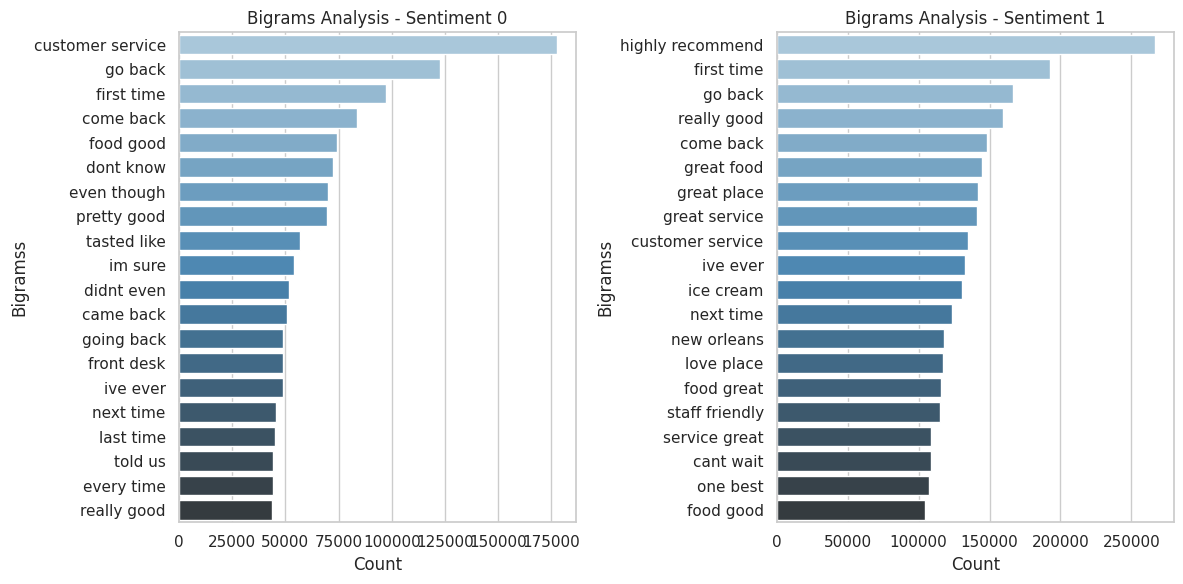

In [12]:
ngram_type = "Bigrams"
num_top_ngrams = 20

sentiment_values = [0, 1]
ngram_counts = generate_and_count_ngrams(df, 2, sentiment_values, num_top_ngrams)
plot_ngrams(ngram_counts, ngram_type, num_top_ngrams)

#### Positive Sentiment

* **High Recommendations**: Bigrams like "highly recommend" and "great place" indicate that positive reviews often contain recommendations and praise for the quality of the place or service.

* **Food and Service Excellence**: Phrases like "great food," "great service," "food great," and "service great" reflect positive opinions about the quality of both the food and the service.

* **Positive Experiences**: Phrases like "first time," "come back," and "love place" suggest that positive reviews often describe enjoyable first-time experiences and express a desire to return.

* **Anticipation**: The presence of phrases like "cant wait" implies that customers look forward to visiting the place again, indicating a high level of satisfaction.

#### Negative Sentiment

* **Customer Service Issues**: Bigrams like "customer service" and "front desk" suggest that negative reviews often contain mentions of problems related to customer service and interactions with staff.

* **Food Quality Concerns**: Bigrams like "good food," "pretty good," and "tasted like" imply that negative reviews often express concerns about the quality and taste of food.

* **Return Reluctance**: The presence of phrases like "go back," "come back," and "going back" implies that customers might be reluctant to return to the same place based on their negative experiences.

* **Mixed Opinions**: Phrases like "even though" and "didn't even" indicate that negative reviews may contain mixed opinions or scenarios where expectations were not met.

#### Conclusion
Based on the results of unigram and bigram analyses, it is evident that customer sentiment in reviews is strongly influenced by the quality of food and service. Positive reviews frequently highlight the great quality of food and service, coupled with recommendations and expressions of loyalty, while negative reviews often point out issues with customer service and concerns about food quality. Negation words are more prevalent in negative reviews, suggesting explicit dissatisfaction. Furthermore, bigrams highlight the importance of return intent, with positive reviews expressing a desire to return and negative reviews indicating reluctance. These insights underscore the significance of delivering exceptional food and service to foster positive customer experiences, encouraging loyalty and recommendations, while addressing service and food quality concerns to mitigate negative sentiment.

## Topic Modeling

Topic modeling analysis was performed to uncover latent thematic structures within the textual data. Unlike n-gram analysis, which focuses on identifying common single words and n-word combinations, topic modeling helps to discover underlying topics or themes present in the dataset. The objective of this analysis was to go beyond surface-level patterns and sentiments, delving into the nuanced topics that customers frequently touch upon in their reviews. 

In [28]:
df_sentiment_0 = df.filter(df["review_sentiment"] == 0)
df_sentiment_1 = df.filter(df["review_sentiment"] == 1)

# Define the stages of the pipeline
tokenizer = Tokenizer(inputCol="review_cleaned_text", outputCol="words")
cv = CountVectorizer(inputCol="words", outputCol="rawFeatures", vocabSize=5000)
idf = IDF(inputCol="rawFeatures", outputCol="features")
lda = LDA(k=10, maxIter=10)

# Apply the pipeline
pipeline_sentiment_0 = Pipeline(stages=[tokenizer, cv, idf, lda])
model_sentiment_0 = pipeline_sentiment_0.fit(df_sentiment_0)

pipeline_sentiment_1 = Pipeline(stages=[tokenizer, cv, idf, lda])
model_sentiment_1 = pipeline_sentiment_1.fit(df_sentiment_1)

# Extract and analyze topics
print("Topics for Sentiment 0:")
vocab_sentiment_0 = model_sentiment_0.stages[1].vocabulary
topics_sentiment_0 = model_sentiment_0.stages[-1].describeTopics(maxTermsPerTopic=10)
for topic in topics_sentiment_0.collect():
    print("Topic {}: {}".format(topic.topic + 1, ", ".join([vocab_sentiment_0[i] for i in topic.termIndices])))

print("\nTopics for Sentiment 1:")
vocab_sentiment_1 = model_sentiment_1.stages[1].vocabulary
topics_sentiment_1 = model_sentiment_1.stages[-1].describeTopics(maxTermsPerTopic=10)
for topic in topics_sentiment_1.collect():
    print("Topic {}: {}".format(topic.topic + 1, ", ".join([vocab_sentiment_1[i] for i in topic.termIndices])))

Topics for Sentiment 0:
Topic 1: room, hotel, stay, rooms, front, desk, one, night, us, parking
Topic 2: delivery, customer, store, service, order, business, called, one, company, time
Topic 3: car, company, told, call, vehicle, back, called, get, said, work
Topic 4: burger, pizza, order, food, ordered, burgers, thai, fries, time, place
Topic 5: told, said, appointment, called, hair, never, time, asked, back, call
Topic 6: store, coffee, always, like, dont, staff, shop, location, get, im
Topic 7: us, table, food, minutes, server, came, waitress, drinks, service, order
Topic 8: bar, place, good, beer, like, food, great, cake, really, nice
Topic 9: pizza, sushi, roll, rolls, place, good, cream, ice, food, like
Topic 10: chicken, good, ordered, sauce, salad, food, cheese, flavor, like, rice

Topics for Sentiment 1:
Topic 1: chicken, sushi, shrimp, fried, good, restaurant, food, ordered, rice, sauce
Topic 2: bbq, burger, sandwich, fries, food, good, great, sauce, delicious, meat
Topic 3: c

### Major Topics
#### Sentiment 0 (Negative):

The topics identified within Sentiment 0 predominantly revolve around negative experiences and challenges faced by customers. Topic 1 highlights issues related to accommodation, with terms like "room," "hotel," and "parking" suggesting discomfort during stays. Topic 2 delves into problems with customer service and business operations, with words like "delivery," "customer," and "service" indicating dissatisfaction. Topics 3 and 5 shed light on difficulties encountered in communication, whether it be with a car company or managing appointments, amplifying the negative sentiment. Additionally, Topic 6 reflects discontent with retail experiences, emphasizing dissatisfaction with stores, staff, and locations. The remaining topics underscore negative aspects of dining experiences, from food orders (Topic 4) to service at bars and restaurants (Topics 7 and 8). Collectively, these topics offer insights into the varied challenges and grievances expressed within the dataset under Sentiment 0.

#### Sentiment 1 (Positive):

Conversely, Sentiment 1 encapsulates positive sentiments within the dataset. The topics here reveal satisfaction and contentment across diverse domains. Topics 1 and 2 highlight positive dining experiences, praising dishes like chicken, sushi, burgers, and sandwiches, with terms like "good," "great," and "delicious" indicating positive sentiment. Topic 3 touches on the delight of coffee and food in general, emphasizing love for specific places. Sentiments related to travel and hospitality are apparent in Topics 5 and 7, discussing positive experiences with hotels, tours, and general service. Topics 6 and 9 delve into positive sentiments regarding personal care, including nail services, haircare, and massages. Finally, Topic 10 explores positive encounters with healthcare professionals, particularly doctors and staff. In summary, Sentiment 1 reveals a spectrum of positive experiences encompassing dining, travel, personal care, and healthcare.

#### Conclusion
The analysis illuminates the nuanced landscape of customer preferences and priorities, emphasizing the crucial role of factors like food quality, service efficiency, anf overall experience in shaping the customer perceptions.

## Sentiment Analysis - VADER

VADER sentiment analysis was employed to delve into the emotional tone of the textual data, providing a quantitative measure of sentiment polarity. The analysis was aimed to understand the prevailing sentiments, their intensity, and how they contribute to the overall sentiment distribution within the dataset.

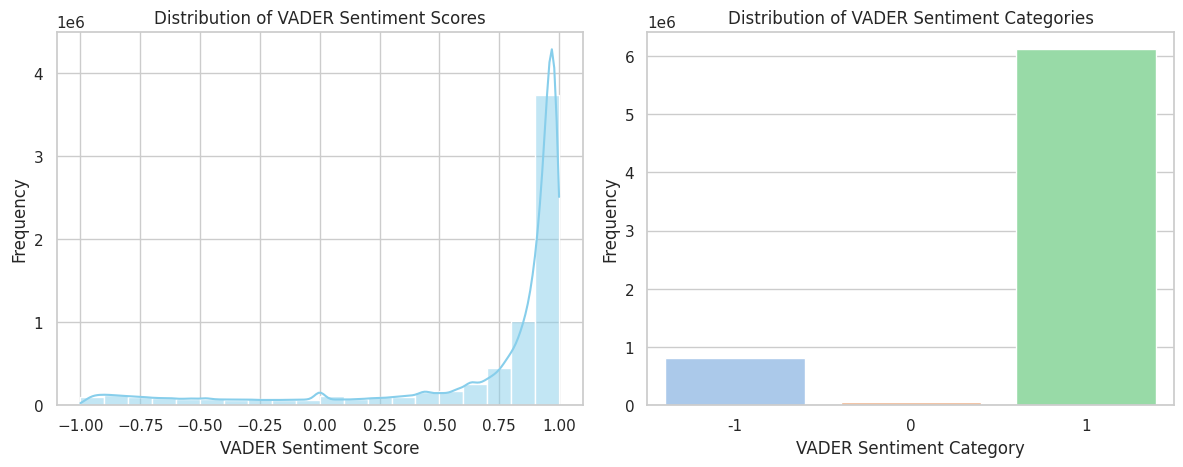

In [27]:
analyzer = SentimentIntensityAnalyzer()

# Function to analyze sentiment using VADER
def analyze_sentiment(text):
    sentiment = analyzer.polarity_scores(text)
    return sentiment['compound']

# Function to categorize sentiment scores
def categorize_sentiment(vader_sentiment_score):
    if vader_sentiment_score < 0:
        return -1
    elif vader_sentiment_score == 0:
        return 0
    else:
        return 1

sentiment_udf = udf(analyze_sentiment, DoubleType())
df = df.withColumn("vader_sentiment_score", sentiment_udf(df["review_cleaned_text"]))

sentiment_categorization_udf = udf(categorize_sentiment, IntegerType())
df = df.withColumn("vader_sentiment", sentiment_categorization_udf(df["vader_sentiment_score"]))

vader_sentiment_scores = df.select("vader_sentiment_score").rdd.flatMap(lambda x: x).collect()
vader_sentiment_categories = df.select("vader_sentiment").rdd.flatMap(lambda x: x).collect()

# Plot a histogram of VADER sentiment scores and count plot for VADER sentiment categories
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.histplot(vader_sentiment_scores, bins=20, color='skyblue', kde=True, ax=axes[0])
axes[0].set_xlabel("VADER Sentiment Score")
axes[0].set_ylabel("Frequency")
axes[0].set_title("Distribution of VADER Sentiment Scores")

sns.countplot(x=vader_sentiment_categories, palette="pastel", ax=axes[1])
axes[1].set_xlabel("VADER Sentiment Category")
axes[1].set_ylabel("Frequency")
axes[1].set_title("Distribution of VADER Sentiment Categories")

plt.tight_layout()
plt.show()

#### Conclusion

The VADER sentiment analysis unveils a prevailing positive sentiment within the examined text data. The majority of sentiment scores are concentrated in the positive range, while occurrences of neutral sentiment are relatively minimal. This outcome reflects an overall optimistic tenor in the text, corroborated by both the sentiment scores and their distribution across the dataset.

## Named Entity Recognition

Named Entity Recognition (NER) analysis was conducted to unveil specific entities and their occurrences within the text data. NER identifies and classifies entities such as names of people, organizations, locations, dates, and more, providing valuable insights into the key elements mentioned in the reviews. By understanding the distribution and frequency of entities, we aimed to gain a deeper understanding of the language used in customer reviews and the specific entities that contribute to the overall content.

In [57]:
# Loading the spaCy English language model
nlp = spacy.load("en_core_web_sm")

# Printing a sample of Named Entity Recognition (NER) visualizations for a randomly selected set of 5 rows
ner_df = df.select("review_cleaned_text").toPandas()
sample_rows = ner_df['review_cleaned_text'].sample(n=5)

for text in sample_rows:
    doc = nlp(text)
    displacy.render(doc, style='ent', jupyter=True)
    print()

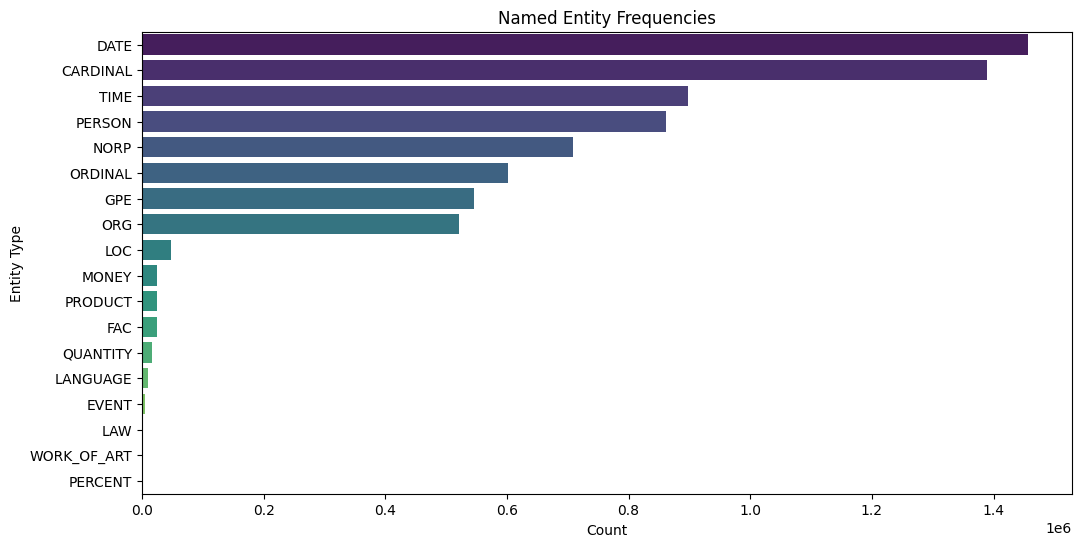

In [39]:
# Function to perform NER on a batch of texts using spaCy's pipeline
def ner_batch(texts):
    docs = list(nlp.pipe(texts))
    return [[X.label_ for X in doc.ents] for doc in docs]

batch_size = 1000
batches = [ner_df['review_cleaned_text'][i:i + batch_size] for i in range(0, len(ner_df), batch_size)]

# Applying NER to each batch concurrently using ThreadPoolExecutor
with concurrent.futures.ThreadPoolExecutor() as executor:
    ent_lists = list(tqdm(executor.map(ner_batch, batches), total=len(batches), desc="Applying NER"))

ent = [x for sublist in ent_lists for x in sublist]
ent_flat = list(chain.from_iterable(ent))

# Count the frequency of each entity label
counter = Counter(ent_flat)
sorted_entities = sorted(counter.items(), key=lambda x: x[1], reverse=True)
entity_frequencies_df = pd.DataFrame(sorted_entities, columns=['Entity', 'Count'])

# Plot bar chart
plt.figure(figsize=(12, 6))
sns.barplot(x='Count', y='Entity', data=entity_frequencies_df, palette='viridis')
plt.title('Named Entity Frequencies')
plt.xlabel('Count')
plt.ylabel('Entity Type')
plt.show()

#### Conclusion
In interpreting the output of the Named Entity Recognition (NER) analysis, it is evident that the dataset predominantly revolves around temporal aspects ('Date') and numerical references ('Cardinal'). This suggests a significant emphasis on discussions related to time and quantifiable elements. Personal entities ('Person') also play a substantial role, indicating a focus on individuals within the context of the analyzed text. Affiliations and group references, as denoted by 'NORP' (Nationalities, Religions, or Political groups) and 'Ordinal' entities, contribute to the dataset's diversity.

The presence of 'GPE' (Geopolitical entities) and 'ORG' (Organizations) further illustrates the contextual backdrop involving locations and organizational affiliations, while 'Loc' (Location) entities are relatively less prominent. Intrestingly, entities associated with finance ('Money'), products, facilities ('Fac'), quantities, languages, and events exhibit negligible significance, suggesting that these aspects have minimal representation in the analyzed text.

## Text Readability

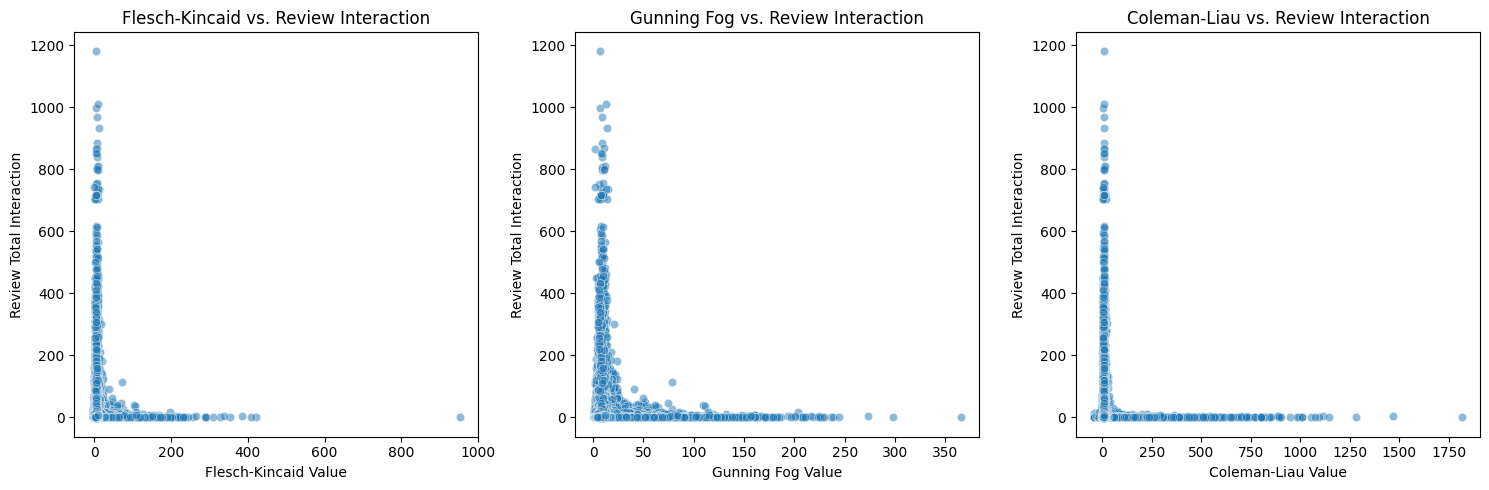

In [10]:
# Define readability metrics and corresponding UDFs
readability_metrics = [
    ("Flesch-Kincaid", textstat.flesch_kincaid_grade),
    ("Gunning Fog", textstat.gunning_fog),
    ("Coleman-Liau", textstat.coleman_liau_index)
]

# Create scatter plots for each readability metric and their relationship with review interaction
fig, axes = plt.subplots(1, len(readability_metrics), figsize=(15, 5))

for i, (metric_name, calculate_readability) in enumerate(readability_metrics):
    readability_udf = udf(calculate_readability, DoubleType())

    df = df.withColumn(metric_name, readability_udf(df["review_text"]))
    readability_df = df.select(metric_name, "review_total_interaction").toPandas()

    sns.scatterplot(data=readability_df, x=metric_name, y="review_total_interaction", alpha=0.5, ax=axes[i])
    axes[i].set_title(f"{metric_name} vs. Review Interaction")
    axes[i].set_xlabel(f"{metric_name} Value")
    axes[i].set_ylabel("Review Total Interaction")

plt.tight_layout()
plt.show()

#### Conclusion

Across all three metrics, the majority of data points cluster around the origin, suggesting that reviews generally exhibit lower levels of text complexity, making them more readable. Specifically, Flesch-Kincaid values are concentrated close to both axes, with a notable density around 200 on the x-axis and up to 600 on the y-axis for review total interaction. Similar patterns are observed in the Gunning Fog and Coleman-Liau plots. 

The distribution indicates that more readable reviews, as indicated by lower complexity scores, receive varying levels of user engagement. This implies that reviews with simpler language structures may attract a broader audience. On the other hand, despite being in the minority, the less readable reviews also show varying levels of user interaction, emphasizing that audience engagement is not solely determined by text simplicity